# ポリコリック相関係数

**ポリコリック相関係数**（polychoric correlation coefficient, **多分相関係数** とも）は順序尺度の変数同士での相関関係を測る係数。



### 推定方法

[小杉考司（2013）](http://kosugitti.sakura.ne.jp/wp/wp-content/uploads/2013/08/polynote.pdf)を参考に、二段階の最尤推定を行う方法を紹介する。

まず、観測された順序尺度の変数の背景に連続尺度の変数が存在し、それらは二変量の標準正規分布に従うと仮定する。
2変量正規分布の空間を閾値で区切って離散化されたものが観測値として実現したと考える。

### 尤度関数

クロス集計表におけるセル$(i, j)$の観測度数を$n_{ij}$とする（$i=1,2,\cdots, s, \ j=1,2,\cdots,r$）。

観測度数がセル$(i, j)$に含まれる確率を$\pi_{ij}$とすれば、そのサンプルの尤度は

$$
L = C \prod^s_{i=1} \prod^r_{j=1} \pi_{ij}^{n_{ij}}
$$

である。ここで$C$は定数で、最尤推定においては推定に関わらないので気にしなくてよい。対数尤度は

$$
\ell = \ln L = \ln C + \sum^s_{i=1} \sum^r_{j=1} n_{ij} \ln \pi_{ij}
$$


相関を測りたい変数が$x,y$の2つあるとし、変数$x$の閾値を$a_i$、変数$y$の閾値を$b_j$と表す（$i=0, 1,2,\cdots, s, \ j=0,1,2,\cdots,r$）。
ここで$a_0 = b_0 = -\infty, a_s = b_r = +\infty$である。

$\pi_{ij}$は相関係数$\rho$の2変数正規分布$\Phi_2$を用いて

$$
\pi_{ij} = \Phi_2(a_i, b_j)
- \Phi_2(a_{i-1}, b_j)
- \Phi_2(a_i, b_{j-1})
+ \Phi_2(a_{i-1}, b_{j-1})
$$

と表すことができる。

### 推定

閾値は次のように推定することができる。

$$
\begin{aligned}
a_i = \Phi_1^{-1}(P_{i \cdot})\\
b_j = \Phi_1^{-1}(P_{\cdot j})
\end{aligned}
$$

ここで$P_{i \cdot}, P_{\cdot j}$は観測された累積周辺分布である。


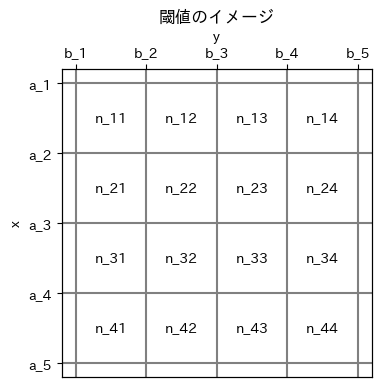

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_fontja

fig, ax1 = plt.subplots(figsize=[4, 4])

k = 5
ticks = range(0, 2 * k, 2)
ticklabels_a = [f"a_{i}" for i in range(1, k + 1)]
ticklabels_b = [f"b_{i}" for i in range(1, k + 1)]

for tick in ticks:
    ax1.axhline(tick, color="gray")
    ax1.axvline(tick, color="gray")

cell_coords = range(1, 2 * k - 1, 2)
for i_show, i in enumerate(cell_coords, start=1):
    for j_show, j in enumerate(cell_coords, start=1):
        ax1.text(j, i, f"n_{i_show}{j_show}", ha="center", va="center")

ax1.set(ylabel="x", xticks=[], title="閾値のイメージ")
ax1.set_yticks(ticks=ticks, labels=ticklabels_a)
ax1.invert_yaxis()

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel("y")
ax2.set_xticks(ticks=ticks, labels=ticklabels_b)
fig.show()

### 推定の流れ

実際に推定してみよう。

次のようなデータがあるとする

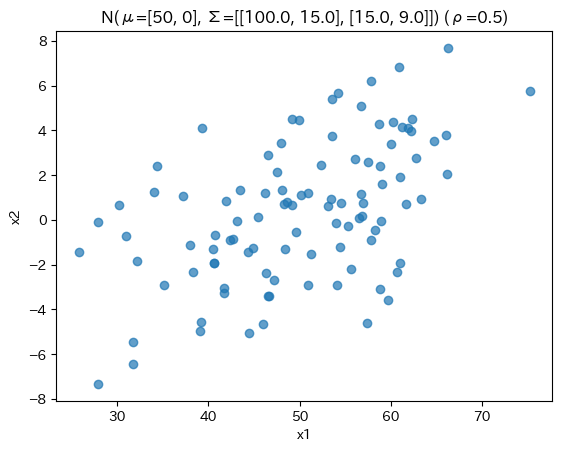

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, pearsonr

# generate data
n = 100
mean = [50, 0]
std = [10, 3]
rho = 0.5
cov = rho * std[0] * std[1]
Cov = np.array([
    [std[0]**2, cov],
    [cov, std[1]**2]
])

X = multivariate_normal.rvs(mean=mean, cov=Cov, size=n, random_state=0)

fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], alpha=.7)
ax.set(xlabel="x1", ylabel="x2", title=f"N(μ={mean}, Σ={Cov.tolist()}) (ρ={rho})")
fig.show()

In [15]:
# 離散化
d1 = X[:, 0] >= X[:, 0].mean()
d2 = np.ones(shape=(n, ))
d2[(-4 <= X[:, 1]) & (X[:, 1] < 4)] = 2
d2[(4 <= X[:, 1])] = 3

D = np.array([d1, d2]).T
D = pd.DataFrame(D, columns=["d1", "d2"]).astype(int)

まずクロス集計表を作って観測度数を得る。

In [16]:
table = pd.crosstab(D["d1"], D["d2"])
table

d2,1,2,3
d1,,,
0,7,39,2
1,1,38,13


クロス集計表を横軸や縦軸に向けて合計していき、累積周辺分布$P_{i \cdot}, P_{\cdot j}$を得る


In [17]:
# 累積周辺分布
n = table.sum().sum()
Pi = table.sum(axis=1).cumsum().to_list() / n
Pj = table.sum(axis=0).cumsum().to_list() / n
print(f"{Pi=} {Pj=}")

Pi=array([0.48, 1.  ]) Pj=array([0.08, 0.85, 1.  ])


$a_i, b_j$を推定する。$a_0 = b_0 = -\infty$、$a_s = b_r = \infty$となるようにする

In [18]:
# 閾値a, bを推定
from scipy.stats import norm
a = norm.ppf(Pi, loc=0, scale=1)
b = norm.ppf(Pj, loc=0, scale=1)

# 簡単のためnp.infを使うが本格的に使う場合は大きな値（10とか100とか）をinfの代わりに使うと尤度が不連続になりづらかった
a = [-np.inf, *a]
b = [-np.inf, *b]

print(f"{a=}")
print(f"{b=}")

a=[-inf, np.float64(-0.05015358346473367), np.float64(inf)]
b=[-inf, np.float64(-1.4050715603096329), np.float64(1.0364333894937898), np.float64(inf)]


確率密度

$$
\pi_{ij} = \Phi_2(a_i, b_j)
- \Phi_2(a_{i-1}, b_j)
- \Phi_2(a_i, b_{j-1})
+ \Phi_2(a_{i-1}, b_{j-1})
$$

の推定と、対数尤度

$$
\ln L = \ln C + \sum^s_{i=1} \sum^r_{j=1} n_{ij} \ln \pi_{ij}
$$

の計算を行う関数を作る

In [19]:
from scipy.stats import multivariate_normal

def log_likelihood(rho, a=a, b=b, table=table):
    Cov = np.array([
        [1, rho],
        [rho, 1]
    ])
    n = np.array(table)
    likelihood = 0
    for i in range(1, len(a)):
        for j in range(1, len(b)):
            ij = multivariate_normal.cdf([a[i], b[j]], mean=[0, 0], cov=Cov)
            ij = 0 if np.isnan(ij) else ij

            i1j = multivariate_normal.cdf([a[i-1], b[j]], mean=[0, 0], cov=Cov)
            i1j = 0 if np.isnan(i1j) else i1j

            ij1 = multivariate_normal.cdf([a[i], b[j-1]], mean=[0, 0], cov=Cov)
            ij1 = 0 if np.isnan(ij1) else ij1

            i1j1 = multivariate_normal.cdf([a[i-1], b[j-1]], mean=[0, 0], cov=Cov)
            i1j1 = 0 if np.isnan(i1j1) else i1j1
            pi = ij - i1j - ij1 + i1j1
            # ちなみにpiの推定は上記のように愚直にやらずとも scipy.stats の mvn.mvnun でもできる

            if pi > 0:
                likelihood += n[i-1, j-1] * np.log(pi)
    return likelihood

log_likelihood(rho=0.1)

np.float64(-135.95432934194218)

尤度を最大にする$\rho$を探索する。

今回は$\rho$が$(-1, 1)$にあることがわかっているので、その範囲を細かく刻んで全部計算して最良の$\rho$を推定値とする、という全探索法をつかうこともできる。

この方法を実際に行ったのが次の図である。

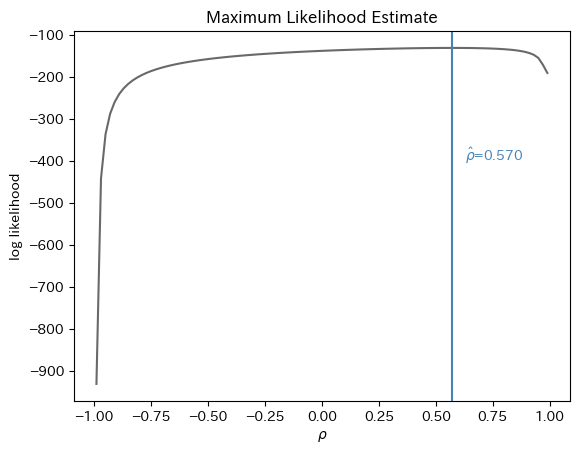

In [20]:
# 最尤推定1: 全探索
rho_range = np.linspace(-0.99, 0.99, 100)
likelihoods = np.array([log_likelihood(rho) for rho in rho_range])
rho_hat = rho_range[np.argmax(likelihoods)]

fig, ax = plt.subplots()
ax.plot(rho_range, likelihoods, color="dimgray")
ax.set(xlabel=r"$\rho$", ylabel="log likelihood", title="Maximum Likelihood Estimate")

l = likelihoods[~np.isinf(likelihoods)]
y = -(l.max() - l.min()) / 2
ax.text(rho_hat * 1.1, y, r"$\hat{\rho}$"+f"={rho_hat:.3f}", color="steelblue")
ax.axvline(rho_hat, color="steelblue")

fig.show()

`scipy.optimize.fminbound`などを使ってBrent法という最適化手法を用いると効率的である。

（実際、`semopy`や`RyStats`などのパッケージではscipyの最適化関数を呼び出すことでBrent法を使っている: [semopy/polycorr.py](https://gitlab.com/georgy.m/semopy/-/blob/master/semopy/polycorr.py)）

In [21]:
# ※minimizeの関数に入れるために負の対数尤度にしている
from scipy.optimize import fminbound
fminbound(lambda rho: -log_likelihood(rho), -0.999, 0.999)

np.float64(0.5697450392309811)

### ポリコリック相関係数の考え方まとめ

2つの順序尺度変数 $X, Y$ があるとし、それぞれ次のように閾値で切って離散化されたと仮定する

$$
\begin{array}{lll}
X=i & \text { if } & \tau_{X, i-1}<X^* \leq \tau_{X, i} \\
Y=j & \text { if } & \tau_{Y, j-1}<Y^* \leq \tau_{Y, j}
\end{array}
$$

ここで

- $X^*, Y^*$ ：潜在的な連続変数
- $\tau_{X, i}, \tau_{Y, j}$ ：それぞれのカデコリに対応するしきい値
- $\left(X^*, Y^*\right) \sim N_2(0,0,1,1, \rho)$ ：平均0、分散 1、相関 $\rho$ の2変量正規分布に従うと仮定

である。

$X, Y$のクロス集計を考えると、観測セル$(i,j)$の確率は、2変量正規分布の累積分布$\Phi_2$で表される

$$
P_{i j} = \operatorname{Pr}(X=i, Y=j)
= \Phi_2\left(\tau_{X, i}, \tau_{Y, j} ; \rho\right)
-\Phi_2\left(\tau_{X, i-1}, \tau_{Y, j} ; \rho\right)
-\Phi_2\left(\tau_{X, i}, \tau_{Y, j-1} ; \rho\right)
+\Phi_2\left(\tau_{X, i-1}, \tau_{Y, j-1} ; \rho\right)
$$

ここで $\Phi_2(a, b; \rho)$ は 平均0・分散1・相関 $\rho$ の2変量正規分布の累積分布関数（CDF）である。

:::{margin}

単変量の場合、 $a<b$の半開区間$(a, b]$の確率は

$$
P(a < X \leq b) = F(b) - F(a)
$$

となる。

同様に2変量正規分布では

$$
P(a_X < X \leq b_X, ~ a_Y < Y \leq b_Y)
=\Phi_2(b_X, b_Y)-\Phi_2(a_X, b_Y)-\Phi_2(b_X, a_Y)+\Phi_2(a_X, a_Y)
$$

となる。
:::

観測されたクロス集計表 $\left\{n_{i j}\right\}$ に基づく尤度関数は

$$
\log L\left(\rho,\left\{\tau_X\right\},\left\{\tau_Y\right\}\right) = \sum_i \sum_j n_{i j} \cdot \log \left(P_{i j}\right)
$$

となる。ここで

- $n_{i j}$ ：カテゴリ $(i, j)$ の観測頻度
- $P_{i j}$ ：上記の矩形積分によって計算される理論確率

である。

$P_{ij}$を計算するときに使う閾値$\tau_X, \tau_Y$は単変量の正規分布の累積分布関数$\Phi_1(\cdot)$を使って次のように推定することができる。

$$
\begin{aligned}
\tau_X = \Phi_1^{-1}(P_{i \cdot})\\
\tau_Y = \Phi_1^{-1}(P_{\cdot j})
\end{aligned}
$$

ここで$P_{i \cdot}, P_{\cdot j}$は観測された累積周辺分布である。

$\tau_X, \tau_Y$を観測値から推定することで、最尤推定する対象は$\rho$だけになる

$$
\hat{\rho} = \operatorname*{arg max}_{\rho} \log L (\rho)
$$

:::{card} 関連文献

- [Olsson, U. (1979). Maximum likelihood estimation of the polychoric correlation coefficient. Psychometrika, 44(4), 443-460.](https://www.cambridge.org/core/journals/psychometrika/article/abs/maximum-likelihood-estimation-of-the-polychoric-correlation-coefficient/62B8AC8F4B0EC5ED7F5B5037A9EAC40D)
- Drasgow, F. (1986). Polychoric and polyserial correlations In: Kotz S, Johnson N, editors. The Encyclopedia of Statistics.
    - こっちのほうが数式は簡潔でわかりやすい

:::

In [22]:
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.optimize import minimize_scalar

def polychoric_correlation(x: np.ndarray, y: np.ndarray, inf: float | int = 100) -> float:
    """
    Estimate the polychoric correlation coefficient between two ordinal variables.

    Parameters
    ----------
    x : np.ndarray
        Ordinal variable X (integer-coded).
    y : np.ndarray
        Ordinal variable Y (integer-coded).
    inf : 閾値推定の上限・下限
        理論上は無限を使うが、数値計算上は別の値のほうが安定しやすい。実験用に指定可能にする

    Returns
    -------
    float
        Estimated polychoric correlation coefficient (rho).
    """

    # Step 1: Ensure inputs are numpy arrays and integer-coded
    x = np.asarray(x)
    y = np.asarray(y)

    if not np.issubdtype(x.dtype, np.integer) or not np.issubdtype(y.dtype, np.integer):
        raise ValueError("Inputs x and y must be integer-coded ordinal variables.")

    # Step 2: Identify unique ordinal levels
    x_levels = np.sort(np.unique(x))
    y_levels = np.sort(np.unique(y))

    # Step 3: Estimate thresholds from empirical marginal proportions
    def estimate_thresholds(values, inf):
        thresholds = []
        levels = np.sort(np.unique(values))
        for level in levels[:-1]:  # exclude top category
            p = np.mean(values <= level)
            thresholds.append(norm.ppf(p))  # τ_i = Φ⁻¹(P(X ≤ i))
        return np.concatenate(([-inf], thresholds, [inf]))

    tau_x = estimate_thresholds(x, inf)  # thresholds for X: τ_X
    tau_y = estimate_thresholds(y, inf)  # thresholds for Y: τ_Y

    # Step 4: Construct contingency table n_ij
    contingency = np.zeros((len(tau_x) - 1, len(tau_y) - 1), dtype=int)
    for i, xi in enumerate(x_levels):
        for j, yj in enumerate(y_levels):
            contingency[i, j] = np.sum((x == xi) & (y == yj))  # n_ij

    # Step 5: Define negative log-likelihood function based on P_ij = Φ₂(τ_i, τ_j; ρ)
    def neg_log_likelihood(rho):
        if not (-0.999 < rho < 0.999):
            return np.inf

        cov = np.array([[1, rho],
                        [rho, 1]])
        log_likelihood = 0.0

        for i in range(len(tau_x) - 1):
            for j in range(len(tau_y) - 1):
                lower = [tau_x[i], tau_y[j]]
                upper = [tau_x[i+1], tau_y[j+1]]

                # P_ij = Φ₂(τ_{i}, τ_{j}) - Φ₂(τ_{i-1}, τ_{j}) - Φ₂(τ_{i}, τ_{j-1}) + Φ₂(τ_{i-1}, τ_{j-1})
                p_ij = multivariate_normal.cdf(upper, mean=[0, 0], cov=cov) \
                     - multivariate_normal.cdf([lower[0], upper[1]], mean=[0, 0], cov=cov) \
                     - multivariate_normal.cdf([upper[0], lower[1]], mean=[0, 0], cov=cov) \
                     + multivariate_normal.cdf(lower, mean=[0, 0], cov=cov)

                p_ij = max(p_ij, 1e-10) # soft clipping
                
                if np.isnan(p_ij):
                    continue

                log_likelihood += contingency[i, j] * np.log(p_ij)

        return -log_likelihood  # minimize negative log-likelihood

    # Step 6: Optimize to find MLE for rho
    result = minimize_scalar(neg_log_likelihood, bounds=(-0.999, 0.999), method="bounded")

    # plot for debug
    rho_range = np.linspace(-0.999, 0.999, 200)
    likelihoods = np.array([neg_log_likelihood(rho) for rho in rho_range])
    rho_hat = rho_range[np.argmin(likelihoods)]
    
    fig, ax = plt.subplots(figsize=[4,3])
    ax.plot(rho_range, likelihoods, color="dimgray")
    ax.set(xlabel=r"$\rho$", ylabel="log likelihood", title="Maximum Likelihood Estimate")
    l = likelihoods[~np.isinf(likelihoods)]
    # y = -(l.max() - l.min()) / 2
    y = np.min(likelihoods)
    ax.text(rho_hat * 1.1, y * 1.5, r"$\hat{\rho}$"+f"={rho_hat:.3f}", color="steelblue")
    ax.axvline(rho_hat, color="steelblue")
    fig.show()
    
    return result.x

閾値の推定のとき下限と上限を無限以外の計算可能な値にすると対数尤度関数が不連続なジャンプをしにくい

np.float64(0.4701461875168032)

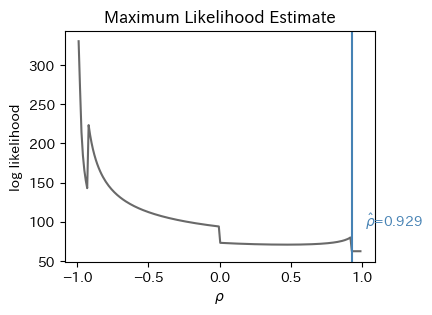

In [23]:
x = D["d1"]
y = D["d2"]
polychoric_correlation(x, y, inf=np.inf)

np.float64(0.5697450392309811)

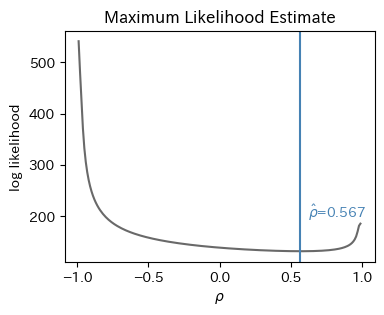

In [24]:
polychoric_correlation(x, y, inf=10)

In [26]:
from ordinalcorr import polychoric
polychoric(x, y)

np.float64(0.569745042555889)